Demo notebook for algorithm evaluation
======================================

The algorithm will be evaluated on three aspects
- Correctness
- Perception
- Efficiency

The evaluation is performed on three tasks 
- Inpainting middle
- Super Resolution $\times 16$
- out painting half
for three images.

# Correctness

Here we check how well the algorithm approximates the posterior distribution $p(x | y)$

For that we work on in a step where we can evaluate explicitly the posterior: **Case of Gaussian Mixture**.

In this setup, we have an analytic expression of the score of the diffusion model, the transition kernels, and more precisely the posterior $p(x | y)$.
We use the Sliced Wasserstein (SW) distance to compare the true posterior with the approximate posterior.

In [2]:
import torch
from torch.distributions import (
    MixtureSameFamily,
    Categorical,
    MultivariateNormal,
)

from utils import load_gmm_epsilon_net
from evaluation.gmm import generate_inverse_problem


dim = 2
n_samples = 300
n_steps = 300
sigma = 0.1

device = "cpu"
torch.set_default_device(device)


# define the prior distribution: #  Gaussian Gaussian
means = torch.tensor(
    [[8 * i, 8 * j] * (dim // 2) for i in range(-2, 3) for j in range(-2, 3)], dtype=torch.float32
)
n_mixtures = means.shape[0]
covs = torch.eye(dim)[None, :].repeat(n_mixtures, 1, 1)
weights = torch.rand(n_mixtures)
weights = weights / weights.sum()

prior = MixtureSameFamily(Categorical(weights), MultivariateNormal(means, covs))

# deduce the posterior
obs, degradation_operator, posterior = generate_inverse_problem(
    prior, dim, sigma, A=torch.tensor([[1, 0]], dtype=torch.float32)
)

# define inverse problem
inverse_problem = (obs, degradation_operator, sigma)

**Note**:
Notice the the ``degradation_operator`` was defined to mask the y-coordinate.
see ``A=torch.tensor([[1, 0]], dtype=torch.float32)``

Next, let's instantiate the diffusion model and use it to solve the inverse problem using DPS algorithm

In [3]:
from sampling.dps import dps


# load diffusion model trained on prior
eps_net = load_gmm_epsilon_net(prior=prior, dim=dim, n_steps=n_steps)

# solve problem
initial_noise = torch.randn((n_samples, dim), device=device)
reconstruction = dps(initial_noise, inverse_problem, eps_net)


/home/obanmarcos/miniconda3/envs/hackathon/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Let's plot the prior, the posterior and the DPS reconstruction to see how they look like

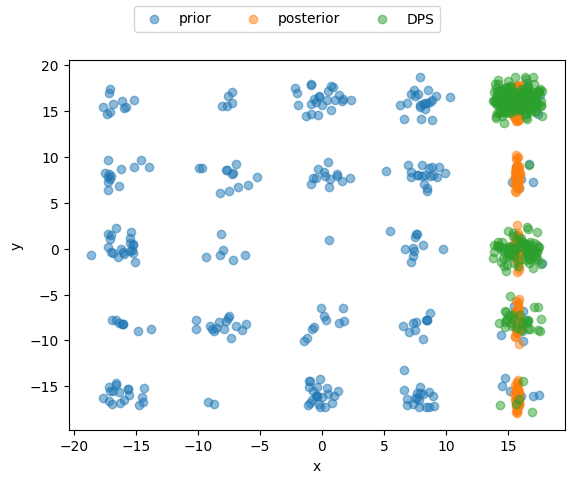

In [6]:
import matplotlib.pyplot as plt

# sample the prior and posterior
samples_prior = prior.sample((n_samples,))
samples_posterior = posterior.sample((n_samples,))

# init figure
fig, ax = plt.subplots()

arr_samples = (samples_prior, samples_posterior, reconstruction)
arr_labels = ("prior", "posterior", "DPS")

# plot
for samples, label in zip(arr_samples, arr_labels):
    ax.scatter(
        samples[:, 0], samples[:, 1], alpha=0.5, label=label
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
fig.legend(loc="upper center", ncols=len(arr_labels))


Finally let's compute the (SW) distance

In [7]:
from evaluation.gmm import sliced_wasserstein

distance = sliced_wasserstein(samples_posterior, reconstruction)

print(f"The sliced Wasserstein distance {distance:.4f}")

The sliced Wasserstein distance 3.9656


# Perception

Here we assess how well the algorithm reconstruction is *perceptually* close to the ground truth.

For that we use the LPIPS metric introduced in [1] which has been shown to match human judgment.
The smaller this metric is, the better.


.. [1] Zhang, Richard, et al. "The unreasonable effectiveness of deep features as a perceptual metric." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.

Let's solve SR16 problem using DPS and compute the LPIPS metric on it

In [8]:
import torch

from utils import load_epsilon_net, load_image
from utils import load_epsilon_net
from sampling.dps import dps

device = "cuda:0"
n_steps = 300
torch.set_default_device(device)


# load the image
img_path = "./material/celebahq_img/00010.jpg"
x_origin = load_image(img_path, device)


# load the degradation operator
path_operator = f"./material/degradation_operators/sr16.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
y = y.squeeze(0)

# add noise
sigma = 0.01
y = y + sigma * torch.randn_like(y)

# define inverse problem
inverse_problem = (y, degradation_operator, sigma)

# load model
eps_net = load_epsilon_net("celebahq", n_steps, device)

# solve problem
initial_noise = torch.randn((1, 3, 256, 256), device=device)
reconstruction = dps(initial_noise, inverse_problem, eps_net)
reconstruction.clamp(-1, 1)

diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


tensor([[[[ 0.5948,  0.5943,  0.5854,  ...,  0.6809,  0.6764,  0.6794],
          [ 0.5690,  0.5640,  0.5619,  ...,  0.6799,  0.6786,  0.6799],
          [ 0.5351,  0.5327,  0.5306,  ...,  0.6768,  0.6783,  0.6741],
          ...,
          [-0.4298, -0.4280, -0.4137,  ...,  0.6301,  0.6264,  0.6106],
          [-0.4900, -0.4830, -0.4746,  ...,  0.6291,  0.6237,  0.6078],
          [-0.5337, -0.5315, -0.5211,  ...,  0.6382,  0.6260,  0.6079]],

         [[ 0.5726,  0.5686,  0.5721,  ...,  0.5671,  0.5695,  0.5654],
          [ 0.5478,  0.5495,  0.5484,  ...,  0.5705,  0.5693,  0.5689],
          [ 0.5236,  0.5205,  0.5221,  ...,  0.5675,  0.5663,  0.5631],
          ...,
          [-0.4372, -0.4306, -0.4201,  ...,  0.5431,  0.5309,  0.5183],
          [-0.4967, -0.4901, -0.4779,  ...,  0.5439,  0.5294,  0.5122],
          [-0.5419, -0.5419, -0.5310,  ...,  0.5394,  0.5307,  0.5135]],

         [[ 0.6034,  0.5988,  0.6001,  ...,  0.5360,  0.5309,  0.5225],
          [ 0.5825,  0.5808,  

Let's plot the results

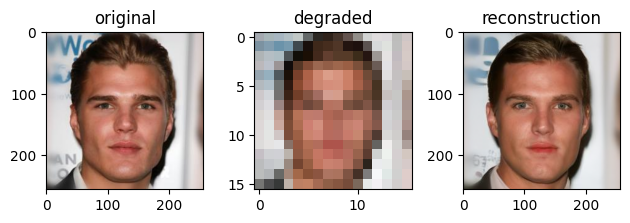

In [9]:
# plot results
import math
from utils import display_image


# reshape y
n_channels = 3
n_pixel_per_channel = y.shape[0] // n_channels
hight = width = int(math.sqrt(n_pixel_per_channel))

y_reshaped = y.reshape(n_channels, hight, width)

# init figure
fig, axes = plt.subplots(1, 3)

images = (x_origin, y_reshaped, reconstruction[0])
titles = ("original", "degraded", "reconstruction")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_image(img, ax)
    ax.set_title(title)

fig.tight_layout()

In [10]:
from evaluation.perception import LPIPS

lpips =  LPIPS()
print(f"lpips: {lpips.score(reconstruction.clamp(-1, 1), x_origin)}")

/home/obanmarcos/miniconda3/envs/hackathon/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/obanmarcos/miniconda3/envs/hackathon/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/obanmarcos/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


100%|██████████| 233M/233M [00:18<00:00, 13.5MB/s] 


Loading model from: /home/obanmarcos/miniconda3/envs/hackathon/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
lpips: 0.11759354174137115


# Efficiency

Here we measure the run time of the algorithm and the memory consumption.

We count time that is need for the algorithm to solve a problem.
Let's look on the previous example.

In [11]:
import time, torch

from utils import load_epsilon_net, load_image
from utils import load_epsilon_net
from sampling.dps import dps

device = "cuda:0"
n_steps = 300
torch.set_default_device(device)


# load the image
img_path = "./material/celebahq_img/00010.jpg"
x_origin = load_image(img_path, device)


# load the degradation operator
path_operator = f"./material/degradation_operators/sr16.pt"
degradation_operator = torch.load(path_operator, map_location=device)

# apply degradation operator
y = degradation_operator.H(x_origin[None])
y = y.squeeze(0)

# add noise
sigma = 0.01
y = y + sigma * torch.randn_like(y)

# define inverse problem
inverse_problem = (y, degradation_operator, sigma)

# load model
eps_net = load_epsilon_net("celebahq", n_steps, device)

# solve problem
initial_noise = torch.randn((1, 3, 256, 256), device=device)

start_time = time.perf_counter()
reconstruction = dps(initial_noise, inverse_problem, eps_net)
finish_time = time.perf_counter()

print(f"Elapsed time: {finish_time -start_time:.5f}")

diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/obanmarcos/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


Elapsed time: 64.99435


In [ ]:
lamb = {0.5, 1, 1.5}
n_steps = {100, 300, 500}
K = {n_steps//10, nsteps//5, nsteps//2}
sigma = {0.01, 0.05, 0.1}

As it is difficult to get the memory consumption of the algorithm, we will deduce it by monitoring the output of ``nvidia-smi -l`` command.
